# Top Greenhouse gases Emitters by Country

In this notebook, we explore which countries contribute the most to global GHG emissions.
We want to identify the top emitters, see how they rank against each other, and start understanding historical trends.
This is our first deep dive into the data beyond simple validation.

## Setting Up the Analysis

First, we'll connect to our database and prepare our tools. This gives us access to all the emissions data we've already cleaned and organized.


In [72]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime, timezone
from sqlalchemy import create_engine
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

ROOT_DIR = Path().resolve().parents[0]
sys.path.append(str(ROOT_DIR))

from src.utils.db_utils import (
    DB_USER,
    DB_PASS,
    DB_HOST,
    DB_PORT,
    DB_NAME,
 )

engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

In [73]:
year = 2024

query = """
SELECT 
    dc.country_name,
    fc.population,
    fc.total_ghg_emissions,
    fc.total_co2_emissions,
    fc.methane_emissions
FROM "FactCountryYearMetrics" AS fc
JOIN "DimYear"    AS dy ON dy.id = fc.year_key
JOIN "DimCountry" AS dc ON dc.id = fc.country_key
WHERE dy.year = %s
  AND fc.total_co2_emissions IS NOT NULL
ORDER BY fc.total_ghg_emissions DESC
LIMIT 10;
"""

df = pd.read_sql(query, engine, params=(year,))

df_formatted = df.copy()
df_formatted["population"]         = df["population"].map("{:,}".format)
df_formatted["total_ghg_emissions"] = df["total_ghg_emissions"].map("{:,.0f}".format)
df_formatted["total_co2_emissions"]  = df["total_co2_emissions"].map("{:,.0f}".format)
df_formatted["methane_emissions"]    = df["methane_emissions"].map("{:,.0f}".format)
df_formatted.index = df_formatted.index + 1

df_formatted

,country_name,population,total_ghg_emissions,total_co2_emissions,methane_emissions
1,China,"1,408,975,000","15,536","13,125","1,485"
2,United States,"340,110,988","5,913","4,632",843
3,India,"1,450,935,791","4,371","3,154",862
4,Russian Federation,"143,533,851","2,576","2,009",417
5,Indonesia,"283,487,931","1,324",812,430
6,Brazil,"211,998,573","1,299",491,621
7,Japan,"123,975,371","1,063",972,51
8,"Iran, Islamic Rep.","91,567,738","1,055",829,176
9,Saudi Arabia,"35,300,280",839,653,113
10,Canada,"41,288,599",768,578,133


### What We're Seeing

The table above shows the 10 countries with the highest total GHG emissions in 2024. **China** dominates by far with 15,536 million tons - almost 3 times more than the **United States** (5,913). Meanwhile, **India** is third with 4,371 million tons. Interestingly, even though India and China have similar populations, China's emissions are much higher. We can also see methane emissions listed separately, which is important because methane is a very powerful greenhouse gas, even though it's usually released in smaller quantities than CO₂. Notice **Brazil** has relatively high methane emissions (621) compared to its total CO₂ (491) - a lot of that comes from agriculture and livestock.


## Bar Chart: Comparing Total GHG Emissions

Let's visualize this data as a bar chart, which makes it easy to compare the emission levels between countries at a glance. The height of each bar shows how much total greenhouse gas each country released.


Text(0.5, 1.0, 'Top 10 Countries by Total GHG Emissions in 2024')

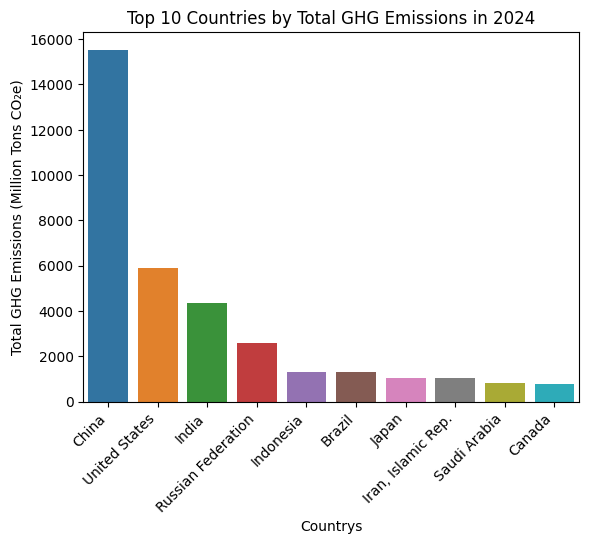

In [74]:
sns.barplot(
    data=df, 
    x="country_name", 
    y="total_ghg_emissions", 
    hue="country_name",
)

plt.xticks(rotation=45, ha="right")
plt.xlabel("Countrys")
plt.ylabel("Total GHG Emissions (Million Tons CO₂e)")
plt.title("Top 10 Countries by Total GHG Emissions in 2024")

### Key Observations from the Bar Chart

- **China** is dramatically ahead - it produces more emissions than the US, India, and Russia combined
- **United States** sits in second place, but is less than half of China's emissions
- There's a big gap between the top 3 (China, US, India) and everyone else
- **Japan** and **Iran** have similar emissions despite being very different countries - it highlights that emissions depend on energy mix, not just size
- This shows us why focusing on these major emitters is important for fighting climate change

## Line Chart: How Emissions Have Changed Over Time

Now let's look at trends. We'll track the top 5 countries over the years to see if their emissions are going up, down, or staying about the same. This helps us understand whether there's progress being made or if emissions are becoming a bigger problem.


### Key Trends to Notice:

- **Indonesia stayed low**: Despite being in the top 5 emitters, Indonesia's CO₂ emissions stayed under 1,000 tons - often they rank high because of methane from agriculture, not CO₂.

- **China's dramatic rise**: Starting from just 1,000 tons in 1970, China's emissions stayed relatively flat until around 2000, then **skyrocketed**. By 2005, it overtook the US, and by 2024 it has more than doubled to over 12,000 tons. This massive increase happened alongside China's rapid industrialization and became the world's "factory."

- **Russia's drop**: You can see Russian emissions actually dipped around 1990 - that's when the Soviet Union collapsed and industrial activity decreased temporarily.

- **United States relatively stable**: The US has stayed around 4,500-5,600 tons for most of the period, with a slight decline in recent years. This suggests they've made some progress on efficiency, even as their economy grew.

- **India climbing steadily**: India shows a slow but steady increase over time, currently around 3,000 tons and still growing as the country develops.

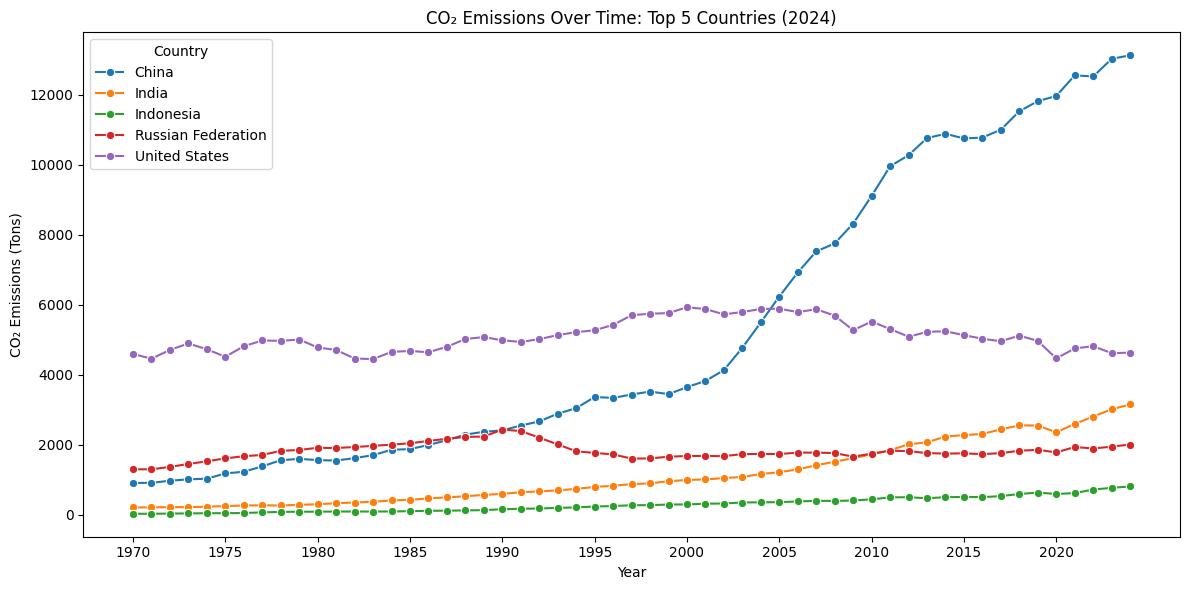

In [75]:
top_n = 5
year = 2024

query = f"""
WITH top_countries AS (
    SELECT fc.country_key, dc.country_name
    FROM "FactCountryYearMetrics" fc
    JOIN "DimYear" dy ON dy.id = fc.year_key
    JOIN "DimCountry" dc ON dc.id = fc.country_key
    WHERE dy.year = {year}
      AND fc.total_co2_emissions IS NOT NULL
    ORDER BY fc.total_ghg_emissions DESC
    LIMIT {top_n}
)
SELECT dy.year AS year, dc.country_name, fc.total_co2_emissions
FROM "DimYear" dy
CROSS JOIN top_countries dc
LEFT JOIN "FactCountryYearMetrics" fc
    ON fc.year_key = dy.id
    AND fc.country_key = dc.country_key
ORDER BY dy.year, dc.country_name;
"""

df = pd.read_sql(query, engine)

df = df[df.groupby('year')['total_co2_emissions'].transform('any')]

plt.figure(figsize=(12,6))
sns.lineplot(
    data=df,
    x='year',
    y='total_co2_emissions',
    hue='country_name',
    marker='o',
    palette='tab10'
)

years = sorted(df['year'].unique())
plt.xticks(years[::max(len(years)//10, 1)], rotation=0)

plt.xlabel('Year')
plt.ylabel('CO₂ Emissions (Tons)')
plt.title(f'CO₂ Emissions Over Time: Top {top_n} Countries ({year})')
plt.legend(title='Country')
plt.tight_layout()
plt.show()

## Summary: What We've Learned

From this initial analysis, we can see that:

1. **China's explosive growth is the biggest story** - It went from minor player in 1970 to the world's biggest emitter by 2005. This acceleration around 2000 matches China's industrial boom. Understanding why and how countries like China got here is crucial.

2. **The US has plateaued** - While China surged, the US held steady around 4,500-5,600 tons. This shows it's possible to maintain economic growth without exploding emissions, though the US is still #2.

3. **India is the next concern** - Slowly climbing from very low emissions, India is now #3. As it continues to develop, its emissions will likely keep rising unless it makes different choices than China did.

4. **Different emission profiles** - Some countries like Brazil get high GHG rankings because of methane from agriculture, not industrial CO₂. This matters when thinking about solutions.

5. **The trend is not improving globally** - Most major emitters are stable or growing. Only Russia showed a big dip, and that was due to economic collapse in 1990, not climate action.